<a href="https://colab.research.google.com/github/Aminm98/Deep-Learning-Final-project/blob/main/CNN_LSTM_aldal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense,Dropout
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from google.colab import drive
import pandas as pd


# Mount Google Drive
drive.mount('/content/drive')
tf.config.list_physical_devices('GPU')

Mounted at /content/drive


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
#Todo check the path
train_in_path='drive/My Drive/Colab Notebooks/Deep Learning/Final Project/CNN_LSTM/input_data_train_3.csv'
train_out_path='drive/My Drive/Colab Notebooks/Deep Learning/Final Project/CNN_LSTM/output_data_train_2_3.csv'
test_in_path='drive/My Drive/Colab Notebooks/Deep Learning/Final Project/CNN_LSTM/input_data_test_3.csv'
test_out_path='drive/My Drive/Colab Notebooks/Deep Learning/Final Project/CNN_LSTM/output_data_test_2_3.csv'

In [ ]:
x_test=np.loadtxt(test_in_path, dtype=np.float32, delimiter=",", skiprows=1)
y_test=np.loadtxt(test_out_path, dtype=np.float32, delimiter=",", skiprows=1)
x_train = np.loadtxt(train_in_path, dtype=np.float32, delimiter=",", skiprows=1)
y_train= np.loadtxt(train_out_path, dtype=np.float32, delimiter=",", skiprows=1)

In [ ]:
def normalize(values):
    mean = np.mean(values)
    values -= mean
    std = np.std(values)
    values /= std
    return values, mean, std
data_len=len(x_train)
wind_tr=x_train[:,0]
cylpo_tr=x_train[:,1]
currentdata_train=x_train[:,2]
past1_train=x_train[:,3]
past2_train=x_train[:,4]
past3_train=x_train[:,5]
past4_train=x_train[:,6]
norm_wind_tr,m_wind_tr,std_wind_tr=normalize(wind_tr)
norm_cylpo_tr,m_cylpo_tr,std_cylpo_tr=normalize(cylpo_tr)
norm_currentdata_train,m_currentdata_train,std_currentdata_train=normalize(currentdata_train)
norm_past1_train,m_past1_train,std_past1_train=normalize(past1_train)
norm_past2_train,m_past2_train,std_past2_train=normalize(past2_train)
norm_past3_train,m_past3_train,std_past3_train=normalize(past3_train)
norm_past4_train,m_past4_train,std_past4_train=normalize(past4_train)

Fex_tr=y_train[:,0]
MM_tr=y_train[:,1]
norm_Fex_tr,m_Fex_tr,std_Fex_tr=normalize(Fex_tr)
norm_MM_tr,m_MM_tr,std_MM_tr=normalize(MM_tr)




In [ ]:

# Reshaping the training and test data for LSTM input
num_features = 7  # Number of features in your input data

# Reshape the training data
x_train = np.stack([
    norm_wind_tr, norm_cylpo_tr, norm_currentdata_train,
    norm_past1_train, norm_past2_train, norm_past3_train, norm_past4_train
], axis=-1)

time_steps = 10  # Number of time steps, including the current time step

# Reshape the data into a 3D structure
# Reshape the 2D array into a 3D array where the last dimension represents time steps
x_train_3d = np.zeros((x_train.shape[0]-time_steps+1, time_steps, x_train.shape[1]))

# Fill the 3D array with sequential time steps for each sample
for i in range(time_steps - 1, x_train.shape[0]):
    for t in range(time_steps):
        x_train_3d[i - time_steps + 1, t, :] = x_train[i - time_steps + 1 + t, :]

y_train_reshaped = np.stack([norm_Fex_tr, norm_MM_tr], axis=-1)


# Reshape the test data
x_test = np.stack([
    normalize(x_test[:, 0])[0],  # Assuming similar normalization function
    normalize(x_test[:, 1])[0],
    normalize(x_test[:, 2])[0],
    normalize(x_test[:, 3])[0],
    normalize(x_test[:, 4])[0],
    normalize(x_test[:, 5])[0],
    normalize(x_test[:, 6])[0]
], axis=-1)


x_test_3d = np.zeros((x_test.shape[0]-time_steps+1, time_steps, x_test.shape[1]))
for i in range(time_steps - 1,x_test.shape[0]):
    for t in range(time_steps):
        x_test_3d[i - time_steps + 1, t, :] = x_test[i - time_steps + 1 + t, :]




def split_train_val(x, y, val_split=0.2):
    # Get the number of samples in the dataset
    num_samples = x.shape[0]

    # Calculate the number of samples for validation
    num_val_samples = int(num_samples * val_split)

    # Generate random indices for shuffling the dataset
    random_indices = np.random.permutation(num_samples)

    # Split the indices into training and validation indices
    val_indices = random_indices[:num_val_samples]
    train_indices = random_indices[num_val_samples:]

    # Create training and validation sets
    x_train, y_train = x[train_indices], y[train_indices]
    x_val, y_val = x[val_indices], y[val_indices]

    return x_train, y_train, x_val, y_val
x_train, y_train,x_val, y_val = split_train_val(x_train_3d, y_train[:-9])

In [ ]:
from keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from keras.models import Model

class MyModel:
    def __init__(self):
        self.model = self.build_model()

    def build_model(self):
        inputs = Input(shape=(10, 7))
        x = Conv1D(filters=32, kernel_size=3, activation='relu')(inputs)
        x = MaxPooling1D(pool_size=1)(x)
        x = LSTM(32, return_sequences=True)(x)
        x = LSTM(32)(x)
        x=Dense(256)(x)
        x=Dropout(0.1)(x)
        outputs = Dense(2)(x)

        model = Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer='adam', loss='mean_squared_error')
        return model

    def train(self, x_train, y_train, x_test, y_test, epochs=300, batch_size=100):
        history = self.model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,
                                 validation_data=(x_test, y_test))
        return history

    def evaluate(self, x_test, y_test):
        loss = self.model.evaluate(x_test, y_test)
        print(f"Test Loss: {loss}")

    def plot_loss(self, history):
        import matplotlib.pyplot as plt
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

num_features = 7  # Number of features in your input data
model_instance2 = MyModel()


Epoch 1/300
3671/3671 [==============================] - 33s 7ms/step - loss: 0.1223 - val_loss: 0.1041
Epoch 2/300
3671/3671 [==============================] - 28s 7ms/step - loss: 0.1022 - val_loss: 0.1075
Epoch 3/300
3671/3671 [==============================] - 30s 8ms/step - loss: 0.0962 - val_loss: 0.0906
Epoch 4/300
3671/3671 [==============================] - 28s 8ms/step - loss: 0.0888 - val_loss: 0.0828
Epoch 5/300
3671/3671 [==============================] - 27s 7ms/step - loss: 0.0811 - val_loss: 0.0789
Epoch 6/300
3671/3671 [==============================] - 26s 7ms/step - loss: 0.0731 - val_loss: 0.0696
Epoch 7/300
3671/3671 [==============================] - 26s 7ms/step - loss: 0.0662 - val_loss: 0.0617
Epoch 8/300
3671/3671 [==============================] - 28s 8ms/step - loss: 0.0599 - val_loss: 0.0556
Epoch 9/300
3671/3671 [==============================] - 27s 7ms/step - loss: 0.0541 - val_loss: 0.0506
Epoch 10/300
3671/3671 [==============================] - 28s 7m

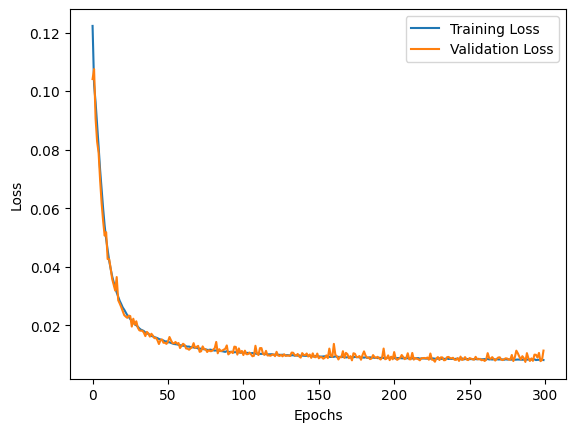

In [ ]:
history = model_instance2.train(x_train, y_train, x_val, y_val)
model_instance2.evaluate(x_val, y_val)
model_instance2.plot_loss(history)

In [ ]:
model_save_path = 'drive/My Drive/Colab Notebooks/Deep Learning/Final Project/CNN_LSTM/Results/BestCNN_LSTM.h5'  # Adjust the path and name as needed
model_instance2.model.save(model_save_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 2s 3ms/step


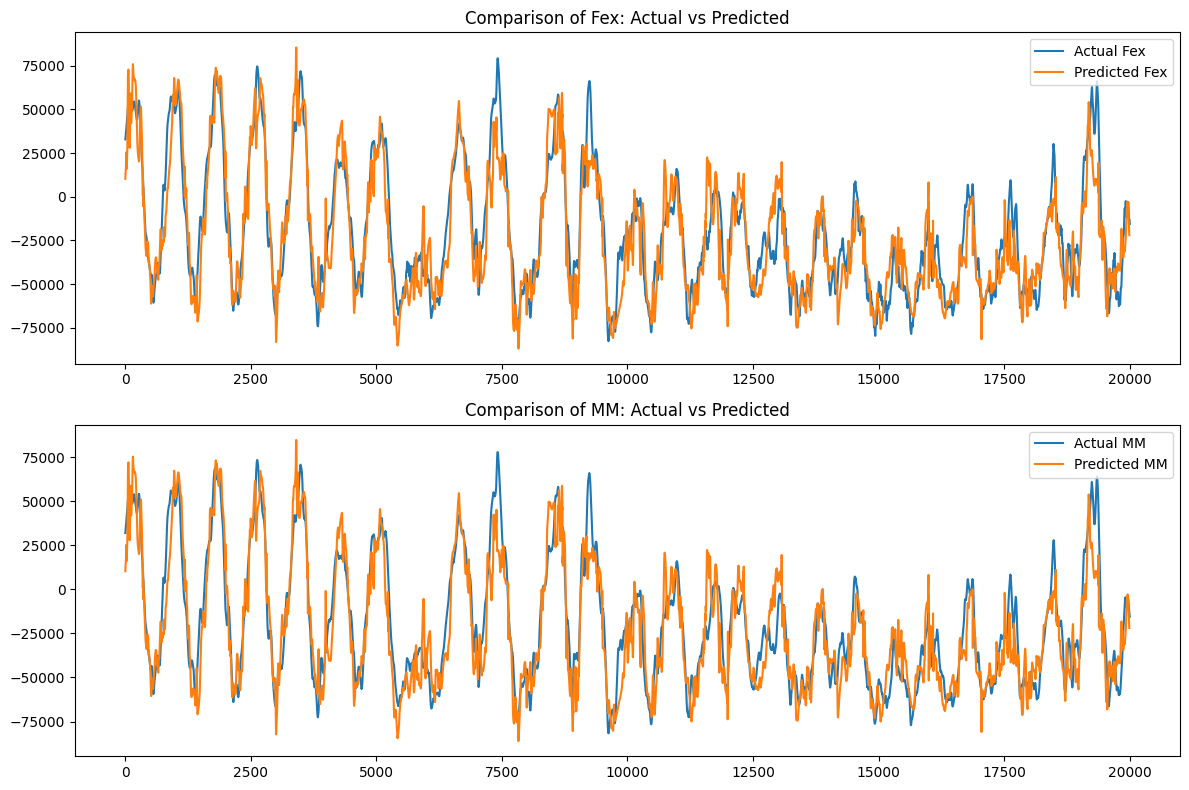

In [ ]:
# Assuming 'y_pred_denormalized' is a NumPy array
def denormalize(normalized_values, mean, std):
    denormalized_values = (normalized_values*std  + mean)
    return denormalized_values
y_pred = model_instance2.model.predict(x_test_3d)
y_pred_denormalized=np.zeros((len(y_pred),2))

# Denormalize the predictions and test labels
y_pred_denormalized[:,0] = denormalize(y_pred[:,0], m_Fex_tr, std_Fex_tr)
y_pred_denormalized[:,1] = denormalize(y_pred[:,1],m_MM_tr, std_MM_tr)
####################################

# Plotting
plt.figure(figsize=(12, 8))

# Plotting for the first output (assuming it's Fex)
plt.subplot(2, 1, 1)
plt.plot(y_test[:, 0], label='Actual Fex')
plt.plot(y_pred_denormalized[:, 0], label='Predicted Fex')
plt.title('Comparison of Fex: Actual vs Predicted')
plt.legend()

# Plotting for the second output (assuming it's MM)
plt.subplot(2, 1, 2)
plt.plot(y_test[:, 1], label='Actual MM')
plt.plot(y_pred_denormalized[:, 1], label='Predicted MM')
plt.title('Comparison of MM: Actual vs Predicted')
plt.legend()

plt.tight_layout()
plt.show()


df = pd.DataFrame(y_pred_denormalized, columns=['Predicted_Fex', 'Predicted_MM'])
df.to_csv('drive/My Drive/Colab Notebooks/Deep Learning/Final Project/CNN_LSTM/Results/y_pred_denormalized.csv', index=False)